# Detecting Malaria With Computer Vision

## Extracting cells with MaskRCNN

In [6]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
from mrcnn.utils import Dataset
from matplotlib import pyplot
%matplotlib inline
from matplotlib.patches import Rectangle
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
import json

BASE_DIR = 'Data\\malaria'

TRAINING_JSON = os.path.join(BASE_DIR, 'training.json')

TRAINING_IMG_COUNT = 100
TESTING_IMG_COUNT = 50

class CellCultureDataset(Dataset):
    def load_json_data(self):
        self.data = json.load(open(TRAINING_JSON))
    def load_dataset(self, is_train=True):
        
        self.add_class("dataset", 1, "cellculture")
        count = -1
        for training_image in self.data:
            count += 1
            if is_train and count > TRAINING_IMG_COUNT:
                continue
            if not is_train and count <= TRAINING_IMG_COUNT:
                continue
            if count > TRAINING_IMG_COUNT + TESTING_IMG_COUNT:
                continue
            img_id = training_image['image']['pathname'][8:-4]
            image_path = os.path.join(BASE_DIR, training_image['image']['pathname'][1:].replace('/', '\\'))
            self.add_image('dataset', image_id=img_id, path=image_path, annotation=training_image)

    def load_mask(self, image_id):
        boxes, w, h = self.extract_boxes(self.image_info[image_id]['annotation'])
        
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        class_ids = []
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('cellculture'))
        return masks, asarray(class_ids, dtype='int32')

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def extract_boxes(self, bbox_data):
        bboxes = []
        for bbox in bbox_data['objects']:
            xmin = bbox['bounding_box']['minimum']['c']
            ymin = bbox['bounding_box']['minimum']['r']
            xmax = bbox['bounding_box']['maximum']['c']
            ymax = bbox['bounding_box']['maximum']['r']
            bboxes.append([xmin, ymin, xmax, ymax])
        img_width = bbox_data['image']['shape']['c']
        img_height = bbox_data['image']['shape']['r']
        return bboxes, img_width, img_height

class CellCultureConfig(Config):
    NAME = "cellculture_cfg"
    NUM_CLASSES = 1 + 1
    STEPS_PER_EPOCH = TRAINING_IMG_COUNT + 1
 

class PredictionConfig(Config):
    # define the name of the configuration
    NAME = "cellculture_cfg"
    # number of classes (background + kangaroo)
    NUM_CLASSES = 1 + 1
    # simplify GPU config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

def evaluate_model(dataset, model, cfg):
    APs = list()
    for image_id in dataset.image_ids:
        # load image, bounding boxes and masks for the image id
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)
        # extract results for first sample
        r = yhat[0]
        # calculate statistics, including AP
        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        # store
        APs.append(AP)
    # calculate the mean AP across all images
    mAP = mean(APs)
    return mAP

# plot a number of photos with ground truth and predictions
def plot_actual_vs_predicted(dataset, model, cfg, n_images=3):
    # load image and mask
    for i in range(n_images):
        # load the image and mask
        image = dataset.load_image(i)
        mask, _ = dataset.load_mask(i)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)[0]
        # define subplot
        pyplot.subplot(n_images, 2, i*2+1)
        # plot raw pixel data
        pyplot.imshow(image)
        extracted_bboxes = dataset.extract_boxes(dataset.image_info[i]['annotation'])[0]
        pyplot.title('Actual - %d cells' % len(extracted_bboxes))
        bx = pyplot.gca()
        # plot each box
        for box in extracted_bboxes:
            # get coordinates
            x1, y1, x2, y2 = box
            # calculate width and height of the box
            width, height = x2 - x1, y2 - y1
            # create the shape
            rect = Rectangle((x1, y1), width, height, fill=False, color='red')
            # draw the box
            bx.add_patch(rect)
        # get the context for drawing boxes
        pyplot.subplot(n_images, 2, i*2+2)
        # plot raw pixel data
        pyplot.imshow(image)
        pyplot.title('Predicted - %d cells' % len(yhat['rois']))
        ax = pyplot.gca()
        # plot each box
        for box in yhat['rois']:
            # get coordinates
            y1, x1, y2, x2 = box
            # calculate width and height of the box
            width, height = x2 - x1, y2 - y1
            # create the shape
            rect = Rectangle((x1, y1), width, height, fill=False, color='red')
            # draw the box
            ax.add_patch(rect)
    # show the figure
    pyplot.show()

def plot_actual_vs_predited_given_image(model, cfg, image_path):
    # Add Image to dataset
    dataset = CellCultureDataset()
    dataset.load_json_data()
    dataset.add_class("dataset", 1, "cellculture")

    wanted_image = None
    for img in dataset.data:
        if img['image']['pathname'] == image_path:
            wanted_image = img
    if wanted_image == None:
        raise ValueError("Unknown image %s" % image_path)

    img_id = 0
    image_path = os.path.join(BASE_DIR, wanted_image['image']['pathname'][1:].replace('/', '\\'))
    dataset.add_image('dataset', image_id=img_id, path=image_path, annotation=wanted_image)
    dataset.prepare()

    # load the image and mask
    image = dataset.load_image(img_id)
    mask, _ = dataset.load_mask(img_id)
    # convert pixel values (e.g. center)
    scaled_image = mold_image(image, cfg)
    # convert image into one sample
    sample = expand_dims(scaled_image, 0)
    # make prediction
    yhat = model.detect(sample, verbose=0)[0]
    # define subplot
    pyplot.subplot(1, 2, 1)
    # plot raw pixel data
    pyplot.imshow(image)
    extracted_bboxes = dataset.extract_boxes(dataset.image_info[img_id]['annotation'])[0]
    pyplot.title('Actual - %d cells' % len(extracted_bboxes))
    bx = pyplot.gca()
    # plot each box
    for box in extracted_bboxes:
        # get coordinates
        x1, y1, x2, y2 = box
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='red')
        # draw the box
        bx.add_patch(rect)
    # get the context for drawing boxes
    pyplot.subplot(1, 2, 2)
    # plot raw pixel data
    pyplot.imshow(image)
    pyplot.title('Predicted - %d cells' % len(yhat['rois']))
    ax = pyplot.gca()
    # plot each box
    for box in yhat['rois']:
        # get coordinates
        y1, x1, y2, x2 = box
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='red')
        # draw the box
        ax.add_patch(rect)
    # show the figure
    pyplot.show()


def display_image(train_set):
    image_id = 0
    image = train_set.load_image(image_id)
    print(image.shape)
    # load image mask
    mask, class_ids = train_set.load_mask(image_id)
    print(mask.shape)
    image_id = 20
    # load the image
    image = train_set.load_image(image_id)
    # load the masks and the class ids
    mask, class_ids = train_set.load_mask(image_id)
    # extract bounding boxes from the masks
    bbox = extract_bboxes(mask)
    # display image with masks and bounding boxes
    display_instances(image, bbox, mask, class_ids, ['', ''])

def train_model(train_set, test_set):
    print('Train: %d' % len(train_set.image_ids))
    print('Test: %d' % len(test_set.image_ids))
    config = CellCultureConfig()
    model = MaskRCNN(mode='training', model_dir='./', config=config)
    model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
    # train weights (output layers or 'heads')
    model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=5, layers='heads')
    
def eval_map(train_set, test_set):
    cfg = PredictionConfig()
    # define the model
    model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
    # load model weights
    model.load_weights('mask_rcnn_cellculture_cfg_0005.h5', by_name=True)
    # evaluate model on training dataset
    train_mAP = evaluate_model(train_set, model, cfg)
    print("Train mAP: %.3f" % train_mAP)
    # evaluate model on test dataset
    test_mAP = evaluate_model(test_set, model, cfg)
    print("Test mAP: %.3f" % test_mAP)

def make_prediction(train_set, test_set):
    cfg = PredictionConfig()
    # define the model
    model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
    # load model weights
    model_path = 'mask_rcnn_cellculture_cfg_0005.h5'
    model.load_weights(model_path, by_name=True)
    # plot predictions for train dataset
    plot_actual_vs_predicted(train_set, model, cfg)
    # plot predictions for test dataset
    plot_actual_vs_predicted(test_set, model, cfg)

def make_prediction_single(image_path):
    cfg = PredictionConfig()
    # define the model
    model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
    # load model weights
    model_path = 'mask_rcnn_cellculture_cfg_0005.h5'
    model.load_weights(model_path, by_name=True)
    plot_actual_vs_predited_given_image(model, cfg, image_path)



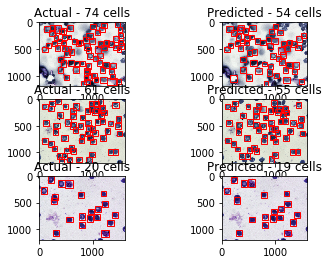

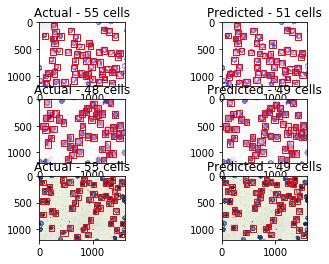

In [9]:
# train set
train_set = CellCultureDataset()
train_set.load_json_data()
train_set.load_dataset()
train_set.prepare()

#display_image(train_set)

test_set = CellCultureDataset()
test_set.load_json_data()
test_set.load_dataset(is_train=False)
test_set.prepare()

#train_model(train_set, test_set)
#eval_map(train_set, test_set)
make_prediction(train_set, test_set)
#make_prediction_single(r"/images/9dc6ed5d-6698-48cf-aab3-fd156673729c.png")

## Extracting cells using Active Contours

We would like to compare extracting cells with a non deep learning technique.
The method that we will attempt to use was used to create the dataset for the kaggle challange.
Since we will train the classifier on that dataset it most suites that we create the individual cell images using the same method.
<br>
<br>
The method that was used is summarized in [this paper](#http://cell.missouri.edu/media/publications/Ersoy_EPAC-red-blood-cells_ISBI-2011.pdf) and uses Level-Set Active Contours with a few changes which make the method apropriate for segmenting RBCs.

links to learn:
 - https://wiseodd.github.io/techblog/2016/11/05/levelset-method/
 - https://wiseodd.github.io/techblog/2016/11/20/levelset-segmentation/
 - 
 